# CS178 Homework 2

## Due Wednesday, October 16th, 11:59pm

---
## Instructions


This homework (and subsequent ones) will involve data analysis and reporting on methods and results
using Python code. You will submit a **single PDF file** that contains everything to Gradescope. This includes any text you wish to include to describe your results, the complete code snippets of how you attempted each problem, any figures that were generated, and scans of any work on paper that you wish to include. It is important that you include enough detail that we know how you solved the problem, since otherwise we will be unable to grade it.

Your homeworks will be given to you as Jupyter notebooks containing the problem descriptions and some template code that will help you get started. You are encouraged to use these starter Jupyter notebooks to complete your assignment and to write your report. This will help you not only ensure that all of the code for the solutions is included, but also will provide an easy way to export your results to a PDF file (for example, doing *print preview* and *printing to pdf*). I recommend liberal use of Markdown cells to create headers for each problem and sub-problem, explaining your implementation/answers, and including any mathematical equations. For parts of the homework you do on paper, scan it in such that it is legible (there are a number of free Android/iOS scanning apps, if you do not have access to a scanner), and include it as an image in the Jupyter notebook.

**Double check that all of your answers are legible on Gradescope, e.g. make sure any text you have written does not get cut off.**

If you have any questions/concerns about using Jupyter notebooks, ask us on EdD. If you decide not to use Jupyter notebooks, but go with Microsoft Word or LaTeX to create your PDF file, make sure that all of the answers can be generated from the code snippets included in the document.

### Summary of Assignment: 100 total points
- Problem 1: k-Nearest Neighbors (25 points)
    - Problem 1.1: Splitting data into training & test sets (10 points)
    - Problem 1.2: Plot predictions for different values of k (10 points)
    - Problem 1.3: Display performance as a function of k & select best (5 points)
    
- Problem 2: Linear Regression (25 points)
    - Problem 2.1: Train the model and plot the data along with its predictions (15 points)
    - Problem 2.2: Compute the MSE loss for the training and evaluation data (10 points)
    
- Problem 3: Feature transformations (25 points)
    - Problem 3.1: Train & display polynomial regression models using feature transforms (10 points)
    - Problem 3.2: Plot the training & evaluation error as a function of degree (10 points)
    - Problem 3.3: Select the best degree for these data (5 points)

- Problem 4: Cross-Validation (20 points)
    - Problem 4.1: Plot the five-fold cross validation error (10 points)
    - Problem 4.2: Select the best degree using cross-validation (5 points)
    - Problem 4.3: Compare cross-validation model selection to hold-out data (5 points)
    
- Statement of Collaboration (5 points)

<center> <img src="http://sli.ics.uci.edu/extras/sep.png" alt="--------------------------------------------" width="200px" height="20px" style="width:200px;height:20px;"/> </center>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.metrics import mean_squared_error as mse

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LinearRegression    # Basic Linear Regression
from sklearn.linear_model import Ridge               # Linear Regression with L2 regularization

from sklearn.model_selection import KFold            # Cross-validation tools

from sklearn.preprocessing import PolynomialFeatures # Feature transformations
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline                # Useful for sequences of transforms

import requests                                      # reading data
from io import StringIO

seed = 1234

# Training / Test Splits

As we've seen in lecture, it is difficult to tell how accurate our model is from only the data on which it has been trained.  For this reason, we usually reserve some data for evaluation, often called "validation" or "test" data.  We'll start by loading a one-dimensional regression data set to use in the rest of the homework.  We will divide this data set into 75% training data, and 25% evaluation data:

In [24]:
url = 'https://www.ics.uci.edu/~ihler/classes/cs178/data/curve80.txt'

with requests.get(url) as link: curve = np.genfromtxt(StringIO(link.text),delimiter=None)

X = curve[:,0:-1]      # extract features
Y = curve[:,-1]        # extract target values

# split into training and evaluation data
Xt, Xe, Yt, Ye = train_test_split(X, Y, test_size=0.25, random_state=seed)

# P1: K-Nearest Neighbor Regression

### P1.1: Visualizing the Data Splits

Plot the data for this regression problem, with the (scalar) feature $x$ along the horizontal axis, and the real-valued target $y$ as the vertical axis.  Plot all the data, displaying the training data $X_t$ in one color, and the evaluation data $X_e$ in a different color.

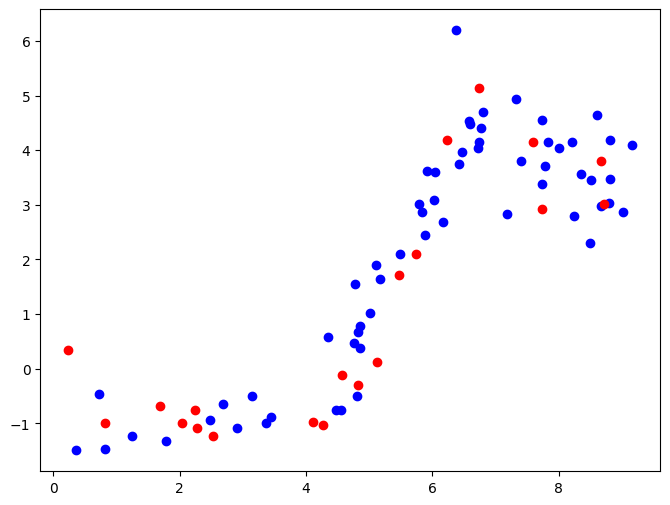

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(Xt, Yt, color='blue', label='Training Data')
plt.scatter(Xe, Ye, color='red', label='Evaluation Data')

plt.show()

### P1.2 Visualizing KNN Regression Predictions

Now use `sklearn`'s `KNeighborsRegressor` class to build a nearest neighbor regression model on your training data.  Build three models, using $k=1$, $k=5$, and $k=20$, and for each one display the training data, test data, and prediction function.  (Note: you can evaluate the prediction function of your learner by predicting at a dense collection of locations `x_spaced` along the x-axis, and then predicting at these points and connecting them using `plot`.)

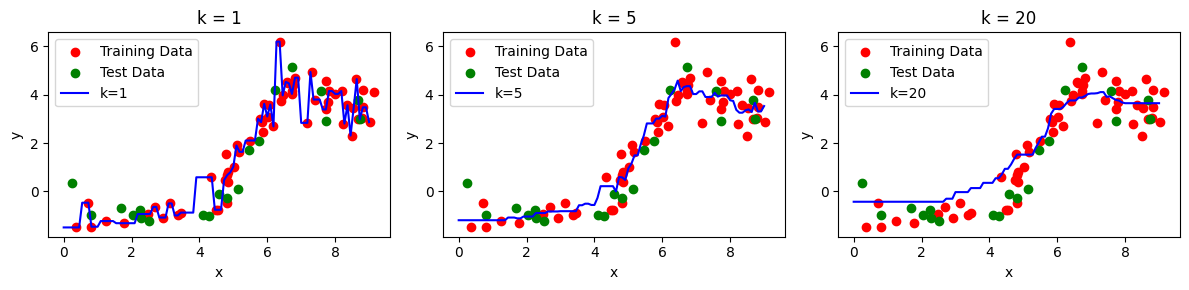

In [26]:
# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

x_spaced = np.linspace(0,9,100).reshape(-1,1)  # get a collection of x-locations at which to plot f(x)

### YOUR CODE STARTS HERE ###

for i, k in enumerate([1, 5, 20]):
    knn = KNeighborsRegressor(n_neighbors=k)  
    knn.fit(Xt, Yt)  
    y_pred = knn.predict(x_spaced)  
    
    axes[i].scatter(Xt, Yt, color='red', label='Training Data')
    axes[i].scatter(Xe, Ye, color='green', label='Test Data')
    axes[i].plot(x_spaced, y_pred, color='blue', label=f'k={k}')
    axes[i].set_title(f'k = {k}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].legend()
###  YOUR CODE ENDS HERE  ###

fig.tight_layout()



### P1.3: KNN Model Selection

Train a model for each $k$ in $1 \leq k \leq 30$, and compute their training and validation MSE.  Plot these values as a function of $k$.  What is the best value of $k$ for your model?

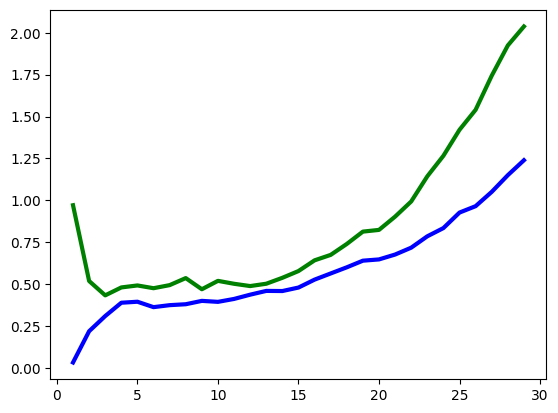

In [27]:
k_values = list(range(1,30))
mse_train = []
mse_eval = []

for i,k in enumerate(k_values):

    ### YOUR CODE STARTS HERE ###

    knn = KNeighborsRegressor(n_neighbors=k)  # Create KNeighborsRegressor model with k neighbors
    knn.fit(Xt, Yt)  # Train the model with the training data
    
    # Compute MSE for training data
    y_train_pred = knn.predict(Xt)
    mse_train_value = np.mean((Yt - y_train_pred) ** 2)
    mse_train.append(mse_train_value)
    # Compute MSE for evaluation (validation) data
    y_eval_pred = knn.predict(Xe) 
    mse_eval_value = np.mean((Ye - y_eval_pred) ** 2)  
    mse_eval.append(mse_eval_value)


    ###  YOUR CODE ENDS HERE  ###

plt.plot(k_values,mse_train,'b-', k_values,mse_eval,'g-', lw=3);

# P2: Linear Regression

### P2.1: Train linear regression model
Now, let's train a simple linear regression model on the training data.  After training the model, plot the training data (colored blue), evaluation data (colored red), and our linear fit (a line) together on a single plot.  Also print out the coefficients (slope, `lr.coef_`, and intercept, `lr.intercept_`) of your model after fitting.

<Figure size 600x400 with 0 Axes>

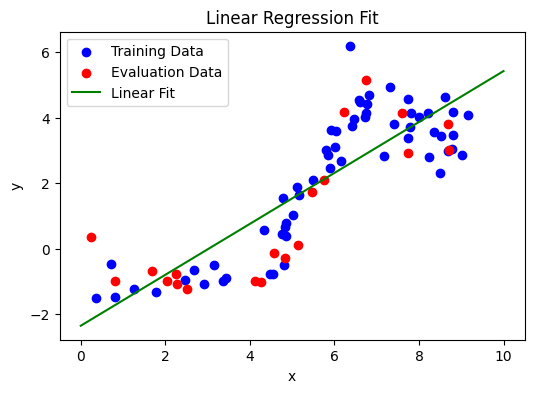

Slope (Coefficient): 0.7768472052927541
Intercept: -2.3463013180118275


In [28]:
plt.figure(figsize=(6,4))

    ### YOUR CODE STARTS HERE ###

lr = LinearRegression()     # create and fit model to training data
lr.fit(Xt, Yt)

# 
x_spaced = np.linspace(0, 10, 200).reshape(-1, 1)
yhat_spaced = lr.predict(x_spaced)

plt.figure(figsize=(6, 4))
plt.scatter(Xt, Yt, color='blue', label='Training Data')
plt.scatter(Xe, Ye, color='red', label='Evaluation Data')
plt.plot(x_spaced, yhat_spaced, color='green', label='Linear Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression Fit')
plt.legend()
plt.show()

print(f"Slope (Coefficient): {lr.coef_[0]}")
print(f"Intercept: {lr.intercept_}")                      # slope & intercept of your fit model

    ###  YOUR CODE ENDS HERE  ###

### P2.2 Evaluate your model's fit

Compute the mean squared error of your trained model on the training data (the data it was fit on) and the held-out evaluation data.

In [29]:

y_train_pred = lr.predict(Xt)
mse_train = np.mean((Yt - y_train_pred)**2)

y_eval_pred = lr.predict(Xe)
mse_eval = np.mean((Ye- y_eval_pred)**2)

print(f"MSE on Training Data: {mse_train}")
print(f"MSE on Evaluation Data: {mse_eval}")

MSE on Training Data: 1.270893125474928
MSE on Evaluation Data: 1.6723519225582435


## Problem 3: Feature Transformations

Often we will want to transform our data (as we saw in class).  A very simple version of this transformation is "normalizing" the data, in which we shift and scale the feature values to a desirable range; typically, zero mean and unit variance, for example.  The ``StandardScaler()`` object in scikit-learn implements such a transformation.

Typically, a pre-processing transformation works in a similar way to training a model: we ``fit`` the object to our training data (in this case, computing the empirical mean and variance of the data), and save the parameters of the transformation (the shift and scale values) so that we can apply exactly the same transformation to subsequent data, for example when asked to predict on a new value of $x$.

So, for example:

In [30]:
scale = StandardScaler().fit(Xt)     # find the desired transformation
X_transformed = scale.transform(Xt)  # & apply it to the training data

# Now, we can train our model on X_transformed...
# lr = LinearRegression()...

# Before we predict, we also need to transform the test point's values:
yhat_spaced = lr.predict(scale.transform(x_spaced))

If you like (and as described in the Discussion code), you can use `sklearn`'s `Pipeline` object to simplify the process of sequentially applying transformations before a predictor.

## P3.1: Train polynomial regression models
As mentioned in the homework, you can create additional features manually, e.g.,

In [31]:
m,n = Xt.shape            # rest of this cell assumes n=1 feature
Xt2 = np.zeros((m,2))
Xt2[:,0] = Xt[:,0]
Xt2[:,1] = Xt[:,0]**2
print (Xt.shape)
print (Xt2.shape)
print (Xt2[0:6,:])   # look at a few data points to check:

(60, 1)
(60, 2)
[[ 0.72580645  0.526795  ]
 [ 2.4769585   6.13532341]
 [ 7.7304147  59.75931143]
 [ 9.0207373  81.37370144]
 [ 8.6751152  75.25762373]
 [ 6.4631336  41.77209593]]


or, you can create them using SciKit's PolynomialFeatures transform object:

In [32]:
Phi = PolynomialFeatures(degree=2,include_bias=False).fit(Xt)
Xt2 = Phi.transform(Xt)
print (Xt2[0:6,:])   # look at the same data points -- same values

[[ 0.72580645  0.526795  ]
 [ 2.4769585   6.13532341]
 [ 7.7304147  59.75931143]
 [ 9.0207373  81.37370144]
 [ 8.6751152  75.25762373]
 [ 6.4631336  41.77209593]]


**Now, try fitting** a linear regression model using different numbers of polynomial features of $x$.

For each degree $d \in \{0,1,3,5,7,10,15,18\}$:

- Fit a linear regression model using features consisting of all powers of $x$ up to degree $d$
    - Make sure you apply ``StandardScaler`` to the transformed data before training
- Plot the resulting prediction function $f(x)$, along with the training and validation data as before


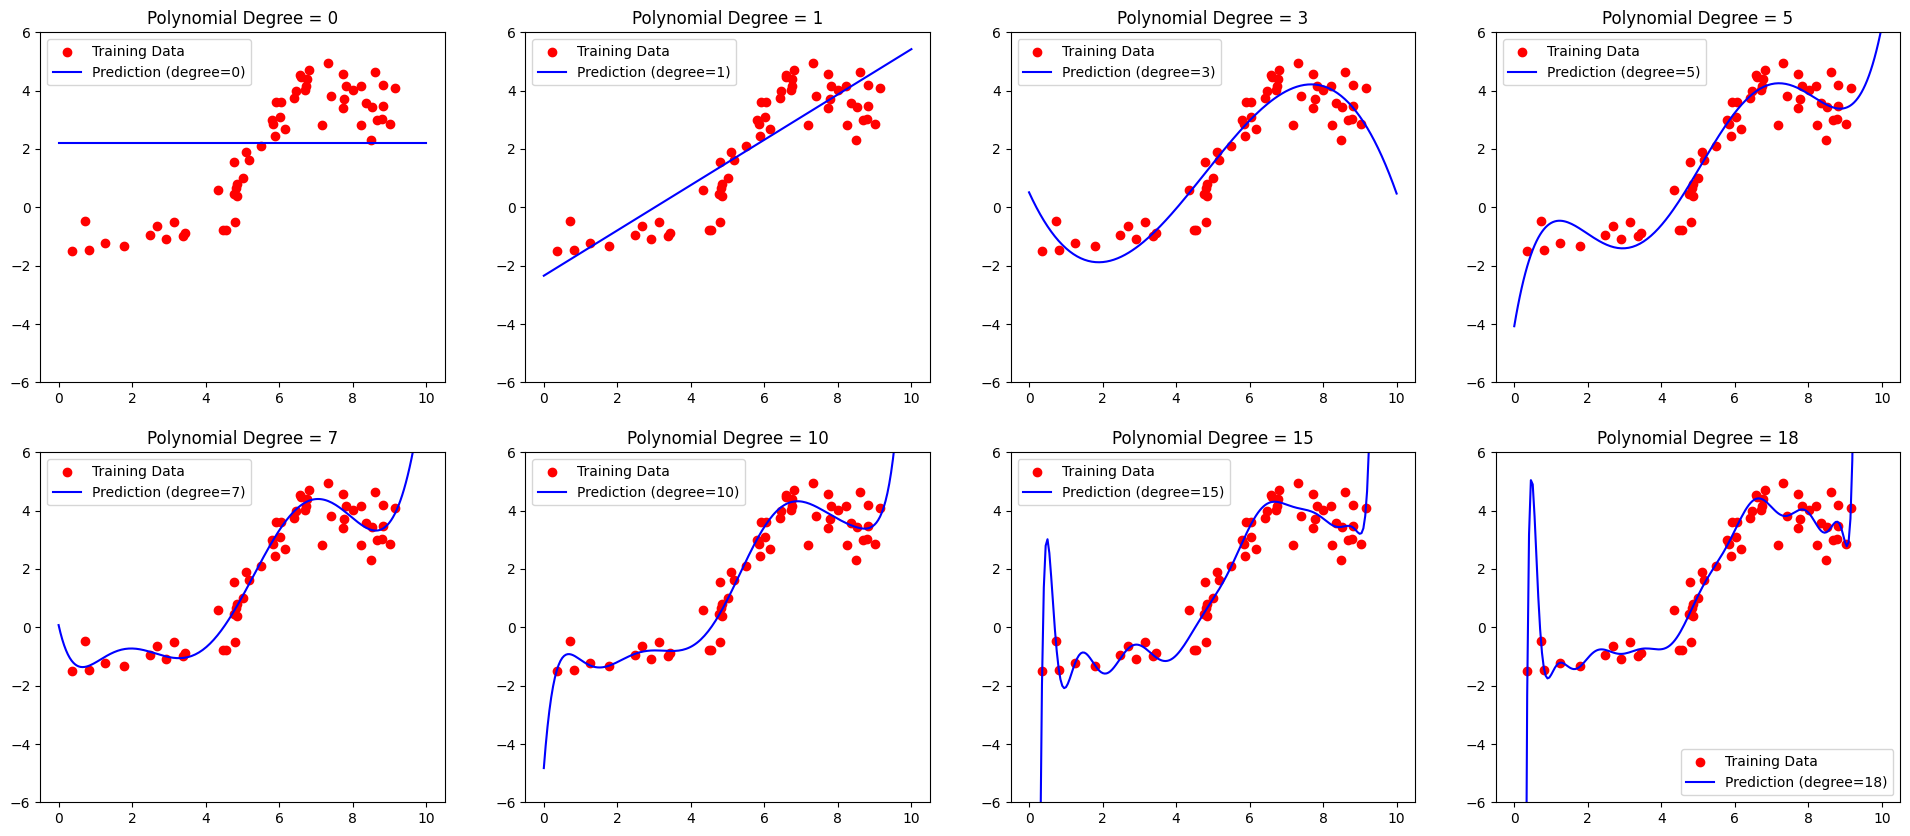

In [33]:
degrees = [0,1,3,5,7,10,15,18]
learners = [ [] ]*len(degrees)

fig, ax = plt.subplots(2,4, figsize=(24,10))

for i,degree in enumerate(degrees):

    ### YOUR CODE STARTS HERE ###
    # Create a polynomial feature expansion of degree d
    poly = PolynomialFeatures(degree=degree)
    Xt_poly = poly.fit_transform(Xt)

    # Use StandardScaler to rescale the transformed data
    scaler = StandardScaler()
    Xt_scaled = scaler.fit_transform(Xt_poly)

    # Fit your linear regression and save it to "learners"
    lr = LinearRegression()
    lr.fit(Xt_scaled, Yt)
    learners[i] = lr

    # Generate predictions for plotting
    x_spaced_poly = poly.transform(x_spaced)
    x_spaced_scaled = scaler.transform(x_spaced_poly)
    y_pred = lr.predict(x_spaced_scaled)

    # Plotting
    axi = ax[i // 4, i % 4]
    axi.scatter(Xt, Yt, color='red', label='Training Data')
    axi.plot(x_spaced, y_pred, color='blue', label=f'Prediction (degree={degree})')
    axi.set_ylim(-6, 6)  
    axi.set_title(f'Polynomial Degree = {degree}')
    axi.legend()

    ###  YOUR CODE ENDS HERE  ###


## P3.2 Model Performance
Compute the mean squared error (MSE) loss of each of your trained models on both the training data and the evaluation data.  Plot these errors as a function of degree (so, degree along the horizontal axis, MSE loss as the vertical axis).

MSE training:  4.372455530451602
MSE testing:  6.0326776831934605
MSE training:  1.2708931254749283
MSE testing:  1.6723519225582444
MSE training:  0.619897130612382
MSE testing:  0.9162172795700394
MSE training:  0.4447150536084293
MSE testing:  0.8597344241311925
MSE training:  0.381686840225152
MSE testing:  0.41582541551910535
MSE training:  0.3574405170455313
MSE testing:  0.6135711005687488
MSE training:  0.33944005147680806
MSE testing:  23.053184112100407
MSE training:  0.3185878809352803
MSE testing:  83.30207256524515


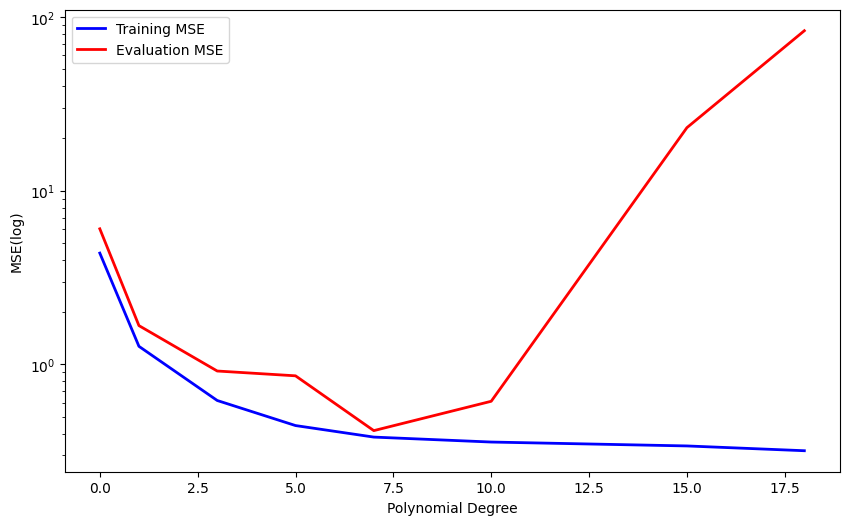

In [34]:
mse_train = [0]*len(degrees)
mse_test = [0]*len(degrees)

for i,degree in enumerate(degrees):
    poly = PolynomialFeatures(degree=degree)
    Xt_poly = poly.fit_transform(Xt)
    Xe_poly = poly.transform(Xe)

    # Rescale the transformed data using the same scaler
    scaler = StandardScaler()
    Xt_scaled = scaler.fit_transform(Xt_poly)
    Xe_scaled = scaler.transform(Xe_poly)

    # Fit the linear regression model
    lr = LinearRegression()
    lr.fit(Xt_scaled, Yt)

    # Compute training and evaluation predictions
    y_train_pred = lr.predict(Xt_scaled)
    y_eval_pred = lr.predict(Xe_scaled)

    # Compute the MSE for training and evaluation data
    mse_train[i] = np.mean((Yt - y_train_pred)**2)
    mse_test[i] = np.mean((Ye - y_eval_pred)**2)
    print("MSE training: ",mse_train[i])
    print("MSE testing: ",mse_test[i])


# Plotting the MSE values
plt.figure(figsize=(10, 6))
plt.semilogy(degrees, mse_train, 'b-', label='Training MSE', lw=2)
plt.semilogy(degrees, mse_test, 'r-', label='Evaluation MSE', lw=2)
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE(log)')
plt.legend()
plt.show()


## P3.3 Model Selection
Which degree would you select to use?

In [35]:
7.5

7.5

# P4: Cross-validation
Cross validation is another method of model complexity assessment.  We use it only to determine the correct setting of complexity-altering parameters ("hyperparameters"), such as how many and which features to use, or parameters like "k" in KNN, for which training error alone provides little information.  In particular, cross validation will not produce a specific model (parameter values), only a setting of the hyperparameter values that cross-validation thinks will lead to a model (parameter values) with low test error.

## P4.1:  5-Fold Cross-validation

In the previous problem, we decided what degree of polynomial fit to use based on the performance on a held-out set of test data.  Now suppose that we do not have access to the target values of those data.  How can we determine the best degree?  

We could perform another split; but since this is reducing the number of data available, let us instead use cross-validation to evaluate the degrees.  Cross-validation works by splitting the training data $X_T$ multiple times, one for eack of the $K$ partitions (``n_splits`` in the code), and repeat our entire training and evaluation procedure on each split:

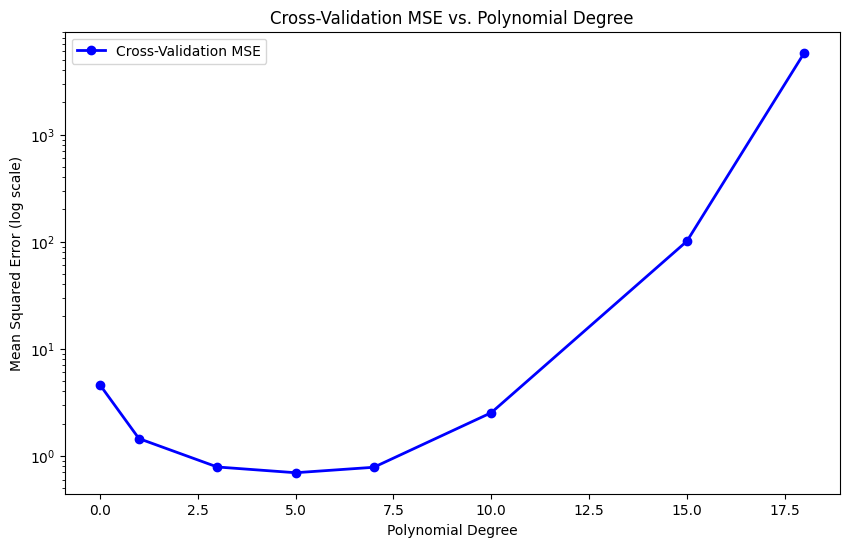

In [36]:
mse_xval = [ 0. ]*len(degrees)

for j,degree in enumerate(degrees):   # loop over desired degree values

    ### YOUR CODE STARTS HERE ###
    mse_folds = []  # Store MSE for each fold

    xval = KFold(n_splits = 5)      # split into k=5 splits

    for train_index, val_index in xval.split(Xt):
        # Extract the ith cross-validation fold (training/validation split)
        Xti,Xvi,Yti,Yvi = Xt[train_index],Xt[val_index],Yt[train_index],Yt[val_index]
        # Create a polynomial feature expansion of degree 'degree'
        poly = PolynomialFeatures(degree=degree)
        Xti_poly = poly.fit_transform(Xti)
        Xvi_poly = poly.transform(Xvi)

        # Create a StandardScaler and scale the features
        scaler = StandardScaler()
        Xti_scaled = scaler.fit_transform(Xti_poly)
        Xvi_scaled = scaler.transform(Xvi_poly)

        # Fit the linear regression model on the training folds
        lr = LinearRegression()
        lr.fit(Xti_scaled, Yti)

        # Compute the MSE on the validation fold
        Yvi_pred = lr.predict(Xvi_scaled)
        mse_folds.append(np.mean((Yvi- Yvi_pred)**2))

    # Evaluate the quality of this degree by averaging the MSE across the five folds
    mse_xval[j] = np.mean(mse_folds)

    ### YOUR CODE ENDS HERE ###

# Plot the estimated MSE from cross-validation as a function of the degree
plt.figure(figsize=(10, 6))
plt.semilogy(degrees, mse_xval, 'bo-', lw=2, label='Cross-Validation MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (log scale)')
plt.title('Cross-Validation MSE vs. Polynomial Degree')
plt.legend()
plt.show()
    ###  YOUR CODE ENDS HERE  ###

## P4.2: Cross-validation model selection

What degree would you choose based on the cross validation performance?

In [37]:
5

5

## P4.3 Comparison to test performance

How do the MSE estimates from 5-fold cross-validation compare to the estimated test performance you found from your held-out data, $X_E$?  Explain briefly.

In [38]:
#T MSE from 5-fold gives a more robust and reliable estimate of the model's true generalization error compared to a single evaluation set. Cross-validation makes better use of the entire dataset. So it is commonly used when selecting model complexity, such as determining the best polynomial degree, and for assessing the overall performance of a machine learning model.

---
### Statement of Collaboration (5 points)

It is **mandatory** to include a Statement of Collaboration in each submission, with respect to the guidelines below. Include the names of everyone involved in the discussions (especially in-person ones), and what was discussed.

All students are required to follow the academic honesty guidelines posted on the course website. For
programming assignments, in particular, I encourage the students to organize (perhaps using EdD) to
discuss the task descriptions, requirements, bugs in my code, and the relevant technical content before they start
working on it. However, you should not discuss the specific solutions, and, as a guiding principle, you are not
allowed to take anything written or drawn away from these discussions (i.e. no photographs of the blackboard,
written notes, referring to EdD, etc.). Especially after you have started working on the assignment, try
to restrict the discussion to EdD as much as possible, so that there is no doubt as to the extent of your
collaboration.

In [39]:
#no other collabrator